# Example: Multiple Asset Geometric Brownian Motion (MGBM)
Consider a portfolio $\mathcal{P}$ with a return covariance matrix $\Sigma$ and drift vector $\mu$.
The multi-dimensional geometric Brownian motion model describing the share price $S_{i}(t)$ for asset $i\in\mathcal{P}$ 
has the analytical solution (in the absence of dividends) given by:
\begin{equation*}
S_{i}(t_{k}) = S_{i}(t_{k-1})\cdot\exp\Biggl[\left(\mu_{i}-\frac{\sigma_{i}^{2}}{2}\right)\Delta{t} + \sqrt{\Delta{t}}\cdot\sum_{j\in\mathcal{P}}a_{ij}\cdot{Z_{j}(0,1)}\Biggr]\quad{i\in\mathcal{P}}
\end{equation*}
where $S_{i}(t_{k-1})$ is the share price at time $t_{k-1}$ for asset $i\in\mathcal{P}$,  $\Delta{t} = t_{k} - t_{k-1}$ is the time difference (step-size) for each time step (fixed), and $Z_{j}(0,1)$ is a standard normal random variable, 
and $a_{ij}\in\mathbf{A}$ and $\mathbf{A}\mathbf{A}^{\top} = \Sigma$, and $\mu_{i}$ denotes the drift parameter for asset $i$. 

## Learning objectives
This example will familiarize students with constructing and simulating multi-asset equity portfolios. The share prices of each asset in the portfolio are computed using multi-asset geometric Brownian motion.

* __Prerequisite__: Load and clean the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-29-2023`
* __Task 1__: Compute the return covariance matrix $\Sigma$ for firms in $\mathcal{D}$
    * `Approach 1`: Use the estimated $(\hat{\mu},\hat{\sigma})$ values from `L5b` and the correlation between firms to compute $\Sigma$.
        * `Check`: Do we recover the values estimated from `L5b`?
    * `Approach 2`: An entirely data-driven approach to estimate the covariance $\Sigma$
* __Task 2__: Visualize the relationship between the returns for two firms
* __Task 3__: Sinulate the price dynamics of the portfolio $\mathcal{P}$ using multiasset geometric Brownian motion
    * `TODO`: Select `tickers` to simulate and compute firm-specific drift and covariance values
    * `TODO`: Compute the $\mathbf{A}$ matrix using Cholesky factorization
        * `Check`: Is our Cholesky factorization legit?
    * `TODO`: Set the initial conditions, the time range, and other parameters for the multi-asset simulation
    * `TODO`: Run the multi-asset simulation to compute future share price trajectories
    * `TODO`: Generate a random allocation $\omega$ for portfolio $\mathcal{P}$, and visualize its performance versus observed prices
        * `Check`: Does the allocation $\omega$ sum to `1`
        * Compute the `simulated` wealth of portfolio $\mathcal{P}$ given allocation $\omega$
        * Compute the `actual` wealth of portfolio $\mathcal{P}$ given allocation $\omega$
        * Visualize `simulated` and `actual` wealth of portfolio $\mathcal{P}$ given allocation $\omega$

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material. 

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable, where the dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable (sorted alphabetically).

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [11]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value), and we'll specify the number of trading days to simulate in the `T` variable:

In [13]:
Δt = (1.0/252.0);
T = 48;
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;

## Task 1: Compute the return covariance matrix $\Sigma$ for firms in ticker set $\mathcal{L}$
We'll use two approaches to estimate the covariance matrix $\Sigma$. We'll use the log growth (return) values in both approaches. Thus, before we begin, let's compute the log growth array for $\mathcal{L}$ firms in `dataset` $\mathcal{D}$ and store this in the `log_growth_array` variable using the [log_return_matrix(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix).
* The `log_growth_array` will be a `N`$\times\dim\mathcal{L}$ array, with time values on the `rows` and firms on the `columns`. Once we have `log_growth_array`, we can use it to compute the correlation (`approach 1`) or compute the $\Sigma$ directly using only the `log_growth_array` values (`approach 2`).

In [15]:
log_growth_array = log_growth_matrix(dataset, list_of_all_firms);

### Approach 1: Use the estimated $(\hat{\mu},\hat{\sigma})$ values from `L5b` and the correlation between firms
The first approach we'll use to estimate the covariance array $\Sigma$ is to use the parameter values from the previous module and directly compute the correlation between growth (return) time series stored in the `log_growth_array` variable.

* First, let's load the `Parameters-SP500-2018-2023.csv` file we saved previously in `L5b` using the `read(...)` function exported by the [CSV.jl package](https://github.com/JuliaData/CSV.jl). We will load this data into a [DataFrame](https://dataframes.juliadata.org/stable/), storing the values in the `parameters_df` variable:

In [17]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA, "Parameters-SP500-2018-2023-Backup.csv"), DataFrame);

Next, let's compute the [correlation](https://en.wikipedia.org/wiki/Correlation) between the firms in the `dataset` $\mathcal{D}$, i.e., between the columns in the `log_growth_array`. We could do this manually; however, we'll use the [cor function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor) exported by the [Statistics module which is part of the Julia standard library](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics). 
* The [cor function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor) takes the `log_growth_array` as an argument and produces the correlation matrix $\rho$, a symmetric $\dim\mathcal{D}\times\dim\mathcal{D}$ matrix where the elements $\rho_{ij}\in\rho$ describe the correlation between the returns of firm $i$ and $j$, and $p_{ii} = 1$. Let's store the correlation matrix in the $\rho$ variable.

In [19]:
ρ = cor(log_growth_array);

Now we can compute the covariance matrix $\Sigma$. The matrix $\Sigma$ is a $\dim\mathcal{L}\times\dim\mathcal{L}$ symmetric array, where $\sigma_{ij}\in\Sigma$ equals $\sigma_{ij} = \sigma_{i}\cdot\sigma_{j}\cdot\rho_{ij}$ and $\sigma_{i}$ denotes the volatility of the returns of firm $i$, and $\rho_{ij}$ denotes the correlation between the return of firm $i$ and $j$.
* We'll use two nested `for` loops to compute $\sigma_{ij}\in\Sigma$. First, let's initialize storage for the $\Sigma$ array in the `Σ₁` variable. In the outer loop (index `i` below), we'll select a `row_ticker` and get its volatility value $\sigma_{i}$.
* We'll then move into the inner loop (index `j` below), where we select a `column_ticker,` get $\sigma_{j}$, the volatility for firm $j$, and look up the correlation between firms $i$ and $j$. Finally, we'll compute $\sigma_{ij} = \sigma_{i}\cdot\sigma_{j}\cdot\rho_{ij}$.

In [21]:
Σ₁ = Array{Float64,2}(undef, length(list_of_all_firms), length(list_of_all_firms));
for i ∈ eachindex(list_of_all_firms)

    row_ticker = list_of_all_firms[i];
    σᵢ = parameters_df[i,:volatility];
    
    for j ∈ eachindex(list_of_all_firms)

        col_tikcer = list_of_all_firms[j];
        σⱼ = parameters_df[j,:volatility];
        Σ₁[i,j] = σᵢ*σⱼ*ρ[i,j];
    end
end

#### Check: Do we recover the values estimated from `L5b`?
The diagonal of the `Σ₁` matrix should be the variance of the return, i.e., $\sigma_{i}^{2}$ for firm $i$. Thus, we can compare the `sqrt` of the diagonal value in the `Σ₁` matrix with the volatility estimated in `L5b`. Let's do this for a random set of firms, in combination with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) and the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox).
* First, let's construct a unique set of firms and store them in the `random_test_ticker_set` variable, where we specify the number of firms in the `number_of_random_firms` variable. We'll construct the `random_test_ticker_set` using a `while` loop.

In [23]:
random_test_ticker_set = Set{String}()
number_of_random_firms = 20;
while (length(random_test_ticker_set) != number_of_random_firms)
    test_ticker = rand(list_of_all_firms)
    push!(random_test_ticker_set,test_ticker)
end

Now, let's test the previous volatility estimates for firm $i$, stored in the `σᵢ` variable, and the values computed from the diagonal values of the `Σ₁` array. We'll use a `rtol = 1e-4` threshold in the `isapprox(...)` function.

In [25]:
for ticker ∈ random_test_ticker_set
    i = findfirst(x-> x==ticker,list_of_all_firms)
    σᵢ = parameters_df[i,:volatility];
    σ̂ᵢ = sqrt(Σ₁[i,i]);
    @assert isapprox(σᵢ,σ̂ᵢ,rtol=1e-4)
end

### Approach 2: An entirely data-driven approach to estimate the covariance $\Sigma$
The second strategy we explore is an entirely data-driven approach in which we estimate the covariance matrix $\Sigma$ directly from the `log_growth_array` values. 
* This is similar to `Approach 1`, except that the volatility for firm $i$ is now estimated from the return data without the intermediate step we used in `L5b` of checking the shape of the return distribution and then estimating the volatility by fitting a model using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).
* `Approach 2` uses the [cov function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov) exported by the [Statistics module, which is part of the Julia standard library](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics). The [cov function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov) takes the `log_growth_array` as an argument and returns the covariance matrix $\Sigma$. Let's store the annualized covariance matrix in the `Σ₂` variable.

In [27]:
Σ₂ = cov(log_growth_array) |> x-> *(x,1/252);

## Task 2: Visualize the relationship between the returns for two firms
Covariance is often difficult to conceptualize. However, it's much easier to understand when we visualize the relationships in two dimensions. For the sake of argument, assume that returns were normally distributed (we know this is not true in most cases, but let's let that go for the time being). 
* Let's create an instance of a [multivariate Normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) where we compute the mean growth (return) values calculated from the `log_growth_array` and use `Σ₁` and `Σ₂` as the covariance. The [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl) exports the [MvNormal type](https://juliastats.org/Distributions.jl/stable/multivariate/#Distributions.MvNormal) which makes this calculation convenient. We can then plot the samples for the `tickers` we selected and visualize the relationship between the growth (return) values.

First, let's select two `tickers` that we want to simulate and store them in the `test_ticker_array` variable:

In [30]:
test_ticker_array = ["GS", "JPM"];

Next, let's select the appropriate values for mean and covariance. We can extract estimates for the mean by computing the mean of the `log_growth_array` for `ticker`$\in$`test_ticker_array`. Similarly, we need to extract the appropriate block from the covariance array.

In [32]:
μ_test_array = Array{Float64,1}(undef,2);
for i ∈ eachindex(test_ticker_array)
    j = findfirst(x->x == test_ticker_array[i],list_of_all_firms);
    μ_test_array[i] = mean(log_growth_array[:,j]);
end
μ_test_array;

In [33]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_number_of_selected_firms = length(test_ticker_array)
Σ₁_test_array = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
Σ₂_test_array = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(test_ticker_array)
    row_firm_index = findfirst(x->x == test_ticker_array[i],list_of_all_firms);
    for j ∈ eachindex(test_ticker_array)
        col_firm_index = findfirst(x->x == test_ticker_array[j],list_of_all_firms);
        Σ₁_test_array[i,j] = Σ₁[row_firm_index, col_firm_index]
        Σ₂_test_array[i,j] = Σ₂[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

In [34]:
m₁ = MvNormal(μ_test_array,Σ₁_test_array);
m₂ = MvNormal(μ_test_array,Σ₂_test_array);

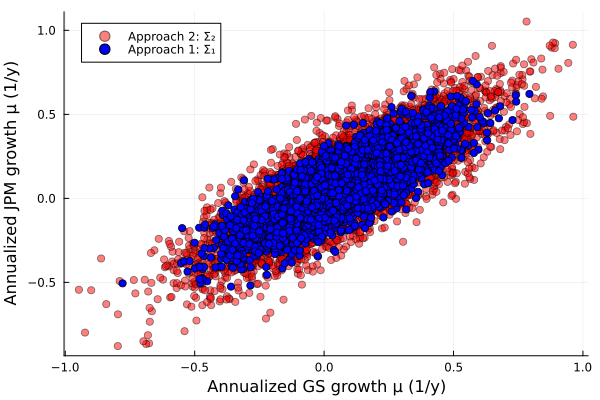

In [35]:
X₁ = rand(m₁,5000)
X₂ = rand(m₂,5000)
scatter(X₂[1,:],X₂[2,:],c=:red, alpha=0.5, label="Approach 2: Σ₂")
scatter!(X₁[1,:],X₁[2,:],c=:blue, label="Approach 1: Σ₁")
xlabel!("Annualized $(test_ticker_array[1]) growth μ (1/y)")
ylabel!("Annualized $(test_ticker_array[2]) growth μ (1/y)")

## Task 3: Compute the dynamics of random portfolios for firms in $\mathcal{L}$
Now that we have the covariance $\Sigma$ and drift parameters $\mu$ from `L5b` (and have used a data-driven alternative to compute these values as well), we can simulate the simultaneous price movement of multiple assets using the multi-asset geometric Brownian motion model.

* First, we select some `tickers`$\in\mathcal{P}$ and compute the drift and covariance for the selected tickers. Then, we generate a random starting time index and initial share price for each ticker. Next, we simulate the share prices for all `tickers`$\in\mathcal{P}$ forward in time. Finally, we compare simulated versus observed market values.

### TODO: Select `tickers` to simulate and compute firm-specific drift and covariance values

In [38]:
my_list_of_tickers = ["AMD", "NVDA", "MU", "INTC"];
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, list_of_all_firms);    
    push!(my_list_of_firm_ids, firm_index)
end

Now that you have selected the firm tickers in your risky portfolio, we'll compute the firm-specific drift vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, we'll construct the drift vector $\hat{\mu}$ using the `parameters_df` values, i.e., the values estimated from the previous module. 
* We initialize storage on `L1` to hold the drift values in the `μ̂` variable (type `Array{Float64,1}`). Then, we iterate through the indexes of our desired firms on `L2`, where for each iteration of the loop, we select the `:drift` field from `parameters_df` and append it (using the [push! function](https://docs.julialang.org/en/v1/base/collections/#Base.push!)) to the `μ̂` array.

In [40]:
μ̂ = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, parameters_df[firm_index,:drift])
end

Next, we'll compute the firm-specific covariance $\hat{\Sigma}$ matrix for the `data` version of the problem. Note, you can use values from `parameters_df,` i.e., the values estimated from the previous module, by switching the covariance matrix to `Σ₁` on `L7`.
* We store the number of firms we have selected in the `my_number_of_selected_firm` variable by calling the [length function](https://docs.julialang.org/en/v1/base/arrays/#Base.length-Tuple{AbstractArray}) on `my_list_of_firm_ids` on `L1`. Then, we allocate storage for the firm-specific covariance `Σ̂` on `L2`, which is of type `Array{Float64,2}`.
* We then use nested `for` loops to fill in the `Σ̂` array values. The outer for loop $i$ iterates over the `rows,` and the inner for loop $j$ iterates over the `columns.` We select values from `my_list_of_firm_ids` (which correspond to the `row, column` coordinates in the original full covariance matrix), select the corresponding covariance value, and store it in the covariance matrix `Σ̂` on `L7`.

In [42]:
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ₂[row_firm_index, col_firm_index]; # You choose either Σ₁ or Σ₂
    end
end

### TODO: Compute the $\mathbf{A}$ matrix using Cholesky factorization 
Finally, we factor the covariance matrix $\Sigma = \mathbf{A}\mathbf{A}^{\top}$ using a [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition) to get the $a_{ij}$ coefficients which appear in the noise term of the multi-asset geometric Brownian motion expression. We'll use the [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition) routine implemented in the [LinearAlgebra.jl package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/) which is part of the [Julia standard library](https://docs.julialang.org/en/v1/)
* On `L1`, we call the [cholesky function](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.cholesky) with the covariance matrix `Σ̂` as an argument. This returns the matrix factorization in the [Cholesky type](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.Cholesky), which has the `L` and `U` fields, holding the `lower` and `upper` triangular factorizations, respectively. We convert the `lower` triangular factor into a [Matrix type](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix) so that we can do computations with it later. We store this matrix in the variable $\mathbf{A}$, where the coefficients $a_{ij}\in\mathbf{A}$.

In [44]:
factors = cholesky(Σ̂);
A = factors.L |> x-> Matrix(x)
Ā = diagm(0 => diag(A))

4×4 Matrix{Float64}:
 0.174191  0.0       0.0       0.0
 0.0       0.151774  0.0       0.0
 0.0       0.0       0.168313  0.0
 0.0       0.0       0.0       0.171799

In [45]:
(factors.U)

4×4 UpperTriangular{Float64, Matrix{Float64}}:
 0.174191  0.088343  0.103682   0.0661902
  ⋅        0.151774  0.0250047  0.0580849
  ⋅         ⋅        0.168313   0.00494155
  ⋅         ⋅         ⋅         0.171799

In [46]:
factors.L

4×4 LowerTriangular{Float64, Matrix{Float64}}:
 0.174191    ⋅          ⋅           ⋅ 
 0.088343   0.151774    ⋅           ⋅ 
 0.103682   0.0250047  0.168313     ⋅ 
 0.0661902  0.0580849  0.00494155  0.171799

#### Check: Is the Cholesky factorization legit?
Before we use the [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition) in our multi-asset simulation, let's check that we can recover the original firm specific covariance matrix `Σ̂`. We know that $\mathbf{A}\mathbf{A}^{\top} = \Sigma$, so let's compare `Σ̂` and the matrix product $\mathbf{A}\mathbf{A}^{\top}$ using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) with `rtol = 1e-6` (or you can choose some other random small value).
* If the `Σ̂` and the matrix product $\mathbf{A}\mathbf{A}^{\top}$ are `NOT` close, i.e., the difference between them is larger than the `rtol` value, the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) will evaluate to `false` and the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) will throw an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError). Otherwise, nothing happens (which is good):

In [48]:
@assert isapprox(Σ̂, A*transpose(A), rtol = 1e-6)

### TODO: Set the initial conditions, the time range, and other parameters
Now, we set up several constants and other data for the multi-asset simulation. Feel free to change these values and see what happens!
* We specify the simulation's starting date in the `startdate` variable, which is a [Date type](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates). For this example, we'll select `Jan-03, 2023`, the first trading day of `2023`.
* We set the number of days we will simulate in the `T` variable and specify the number of sample paths we want to compute in the `number_of_trials` variable.
* The other variables, i.e., `Δt,` and `number_of_states,` are derived from the other constants or specified. 

In [50]:
startdate = Date(2023,01,03); # must be in the date range of the data, i.e., 03-Jan 2018 to 29-Dec, 2023
T = 250; # how many days will we simulate?
number_of_trials = 500; # number of sample paths we calculate

start_index = 1; # we are starting at the beginning of the year
stop_index = start_index + T

# ---- DO NOT CHANGE BELOW HERE ---------------------------- #
Δt = (1/252);
number_of_states = length(my_list_of_tickers);
# ---- DO NOT CHANGE ABOVE HERE ---------------------------- #

Next, get the initial share price, which we approximate as the [volume weighted average price or `VWAP`](https://en.wikipedia.org/wiki/Volume-weighted_average_price)  for each asset in the portfolio for the `startdate`.  We store these values in the `Sₒ::Array{Float64,1}` variable.
* First, on `L1`, we initialize storage to hold the initial prices in the `Sₒ` variable, which is of type `Array{Float64,1}`. Then, we iterate through each `ticker` value in `my_list_of_tickers,` select the price data for `ticker` from `dataset,` and store it in the `price_df` variable (which is of type [DataFrame](https://dataframes.juliadata.org/stable/)).
* `L4` is a compound statement in which we first select trading days equal to or after the `startdate` from `price_df`, then select the first `VWAP` from this list and set it equal to the `startprice` variable.
* `L5` we use the [push! function](https://docs.julialang.org/en/v1/base/collections/#Base.push!) to add initial `VWAP` values to the `Sₒ` array.

In [52]:
Sₒ = Array{Float64,1}()
for ticker ∈ my_list_of_tickers
    price_df = dataset[ticker];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:volume_weighted_average_price]
    push!(Sₒ,startprice)
end

### TODO: Run the multi-asset simulation to compute the share price trajectories
Following from the single asset case, we construct an instance of [the `MyMultipleAssetGeometricBrownianMotionEquityModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyMultipleAssetGeometricBrownianMotionEquityModel), where we pass the drift vector $\mu$ and the factored covariance matrix $\mathbf{A}$ into [a `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMultipleAssetGeometricBrownianMotionEquityModel},%20NamedTuple}):

In [54]:
model = build(MyMultipleAssetGeometricBrownianMotionEquityModel, (
        μ = μ̂, A = A
));

Then we pass the start time `T₁,` the stop time `T₂`  for the simulation, the initial conditions `Sₒ,` the time step `Δt,` and other simulation parameters along with the `model` instance into the `sample(...)` function. This function computes `number_of_paths` sample paths and returns the simulated data in the `simulation_dictionary` variable.
* The `simulation_dictionary` data structure holds a simulation array for each sample path, where the simulation array has time in the first column and the simulated price for each asset in columns $2\dots\dim\mathcal{L}$. Each row is a time value; there will be `T+1` rows for each simulation array.

In [56]:
T₁ = start_index*Δt
T₂ = stop_index*Δt
simulation_dictionary = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = number_of_trials);

For example, we can access the data `samplepath = 1` by issuing the command:

In [115]:
simulation_dictionary[1];

### TODO: Generate a random allocation $\omega$ for portfolio $\mathcal{P}$
First, let's specify how much we wish to invest in risky assets, and store this value in the `total_budget` variable:

In [60]:
total_budget = 1000.0;

Next, let's simulate the allocation of the `total_budget` to each `ticker`$\in\mathcal{P}$. Let the fraction of the investment budget allocated to firm $i$ be denoted as $\omega_{i}\in\omega$, where $\omega_{i}>0$ and $\sum_{i\in\mathcal{P}}\omega_{i} = 1$ (full allocation, all risky assets).
* Later, we'll discuss [Modern Portfolio Theory (MPT)](https://en.wikipedia.org/wiki/Modern_portfolio_theory), which is a technique to `optimally compute` the fraction of the investment budget allocated to each asset in a portfolio. However, for now, let's generate a random allocation vector $\omega$ using the [Dirichlet distribution](https://juliastats.org/Distributions.jl/stable/multivariate/#Distributions.Dirichlet) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl).
* If $x_{i}\in{X}$ are random draws from a [Dirichlet distribution](https://juliastats.org/Distributions.jl/stable/multivariate/#Distributions.Dirichlet), each $x_{i}>0$ and $\sum_{i}x_{i} = 1$.

In [62]:
ω = (1/number_of_states)*ones(number_of_states) |> x -> Dirichlet(x) |> d->rand(d);

#### Check: Does the allocation $\omega$ sum to `1`
Let's check that our allocation satisfies the `non-negativity` and `summation` properties of a capital allocation $\omega$ vector using the `@assert macro`. If this check fails, it will throw an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) (in both cases):

In [64]:
# Check: non-negativity constraint
for ωᵢ ∈ ω
    @assert ωᵢ ≥ 0.0
end

In [65]:
# Check: summation constraint
@assert sum(ω) ≈ 1.0 rtol = 1e-4 

Now that we have the `total_budget`, an allocation vector $\omega$, and the share price array `Sₒ`, we compute the number of shares of each asset that corresponds to the random allocation and store these values in the `Nₒ::Array{Float64,1}` variable. 
* Each entry in the `Nₒ` array is the initial number of shares we purchase at the start of the investment. For this case study, we allow for fractional shares:

In [67]:
Nₒ = Array{Float64,1}()
for i ∈ eachindex(ω)
    
    ωᵢ = ω[i]
    nᵢ = (ωᵢ*total_budget)/Sₒ[i];
    push!(Nₒ,nᵢ)
end
Nₒ;

#### Compute the `simulated` wealth of portfolio $\mathcal{P}$ given allocation $\omega$
`Unihide` the code block below to see how we computed the __simulated wealth__ of the portfolio $\mathcal{P}$ for the parameters specified above. We store the simulation data in the `simulated_wealth_array::Array{Float64,2}` variable.

In [69]:
simulated_wealth_array = let

    number_of_days = T
    simulated_wealth_array = Array{Float64,2}(undef, number_of_days, number_of_trials);
    for i ∈ 1:number_of_trials
        
        simulation_array = simulation_dictionary[i]
        
        portfolio_performance_array = Array{Float64,2}(undef, number_of_days, length(ω)+1)
        for j ∈ eachindex(my_list_of_tickers)
        
            ticker = my_list_of_tickers[j];
            price_data = simulation_array[:,j+1];
            nⱼ = Nₒ[j]
        
            for k ∈ 1:number_of_days
                portfolio_performance_array[k,j] = nⱼ*price_data[k];
            end
        end
    
        # total -
        for j ∈ 1:number_of_days
            portfolio_performance_array[j,end] = sum(portfolio_performance_array[j,1:end-1])
        end
        
        # wealth -
        for j ∈ 1:number_of_days
            simulated_wealth_array[j,i] = portfolio_performance_array[j,end];
        end
    end
    simulated_wealth_array;
end

250×500 Matrix{Float64}:
 1000.0    1000.0    1000.0    1000.0    …  1000.0    1000.0    1000.0
  994.969  1010.13   1000.11    994.734      997.564   985.677  1001.38
  988.851  1016.07    988.73    993.577      984.08    979.872   996.518
  989.36   1023.8    1011.21   1009.34       978.695   992.9    1000.17
  990.914  1029.44   1004.62   1011.07       999.847  1022.7    1002.09
  986.236  1035.5     998.211   992.395  …  1007.13   1011.99    995.564
  989.07   1048.01    998.144  1010.44      1013.45   1007.77    984.855
 1009.27   1060.11   1003.62   1005.46       988.557  1022.94    993.785
 1011.38   1051.24   1005.91    983.409      988.858  1013.38    993.123
 1017.81   1035.62   1004.68    994.551      981.392  1015.85    995.333
 1010.44   1018.54    992.449   995.725  …   982.525  1020.54    996.78
 1000.27   1020.41    970.265   997.587      986.111  1032.48   1003.9
 1025.94   1013.05    966.314   991.967     1015.22   1022.69   1003.05
    ⋮                              

#### Compute the `actual` wealth of portfolio $\mathcal{P}$ given allocation $\omega$
`Unihide` the code block below to see how we computed the __actual wealth__ of the portfolio $\mathcal{P}$ for the parameters specified above. We store the simulation data in the `actual_portfolio_performance_array::Array{Float64,2}` variable.

In [71]:
# actual -
actual_portfolio_performance_array = let

    number_of_days = T
    actual_portfolio_performance_array = Array{Float64,2}(undef, number_of_days, length(ω)+1)
    for i ∈ eachindex(my_list_of_tickers)
        
        ticker = my_list_of_tickers[i];
        price_df = dataset[ticker];
        ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
        nᵢ = Nₒ[i]
        
        for j ∈ 1:number_of_days
            actual_portfolio_performance_array[j,i] = nᵢ*ticker_data[j,:volume_weighted_average_price];
        end
    end
    
    # total -
    for i ∈ 1:number_of_days
        actual_portfolio_performance_array[i,end] = sum(actual_portfolio_performance_array[i,1:end-1])
    end
    actual_portfolio_performance_array;
end

250×5 Matrix{Float64}:
 11.8453   985.49   2.53844  0.125905  1000.0
 11.9714   994.468  2.57057  0.126127  1009.14
 11.9351   986.803  2.59544  0.126133  1001.46
 12.0046  1003.57   2.63767  0.129006  1018.34
 11.7818  1000.17   2.56495  0.128393  1014.65
 11.6751   993.029  2.54662  0.12723   1007.38
 11.6116   984.913  2.54055  0.128122   999.193
 11.6041   980.914  2.56123  0.12768    995.207
 11.562    982.438  2.56799  0.127431   996.696
 11.5244   986.164  2.5465   0.127304  1000.36
 11.3439   962.273  2.50905  0.124736   976.251
 11.3413   938.761  2.51926  0.122908   952.744
 11.2451   929.97   2.51398  0.123262   943.853
  ⋮                                    
 10.3175   967.37   2.44273  0.134551   980.265
 10.4255   952.209  2.43033  0.134093   965.199
 10.3391   937.739  2.41585  0.134251   950.628
 10.375    955.88   2.43599  0.13597    968.827
 10.4104   954.723  2.44073  0.136433   967.711
 10.2857   945.374  2.43495  0.1362     958.231
 10.3066   941.319  2.4385   0.13

#### Visualize `simulated` and `actual` wealth of portfolio $\mathcal{P}$ given allocation $\omega$
`Unhide` the code block below to see how we plotted the performance of the `simulated` and `actual` portfolio $\mathcal{P}$ with a random allocation $\omega$.

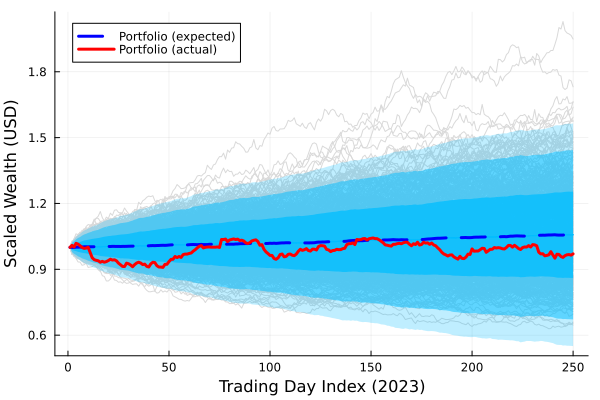

In [73]:
let
    p = plot();
    
    # plot the trajectories -
    for i ∈ 1:number_of_trials
        plot!((1/total_budget)*simulated_wealth_array[:,i],c=:gray85,lw=1, label="")
    end
    
    # compute the expected wealth array, and bounds 0
    expected_wealth_array = mean(simulated_wealth_array,dims=2)
    L68 = (1/total_budget)*(expected_wealth_array .- std(simulated_wealth_array,dims=2))
    U68 = (1/total_budget)*(expected_wealth_array .+ std(simulated_wealth_array,dims=2))
    plot!((1/total_budget)*expected_wealth_array,fillrange=L68, c=:deepskyblue1, alpha=0.75,label="")
    plot!((1/total_budget)*expected_wealth_array,fillrange=U68, c=:deepskyblue1, alpha=0.75, label="")
    
    L95 = (1/total_budget)*(expected_wealth_array .- 1.96*std(simulated_wealth_array,dims=2))
    U95 = (1/total_budget)*(expected_wealth_array .+ 1.96*std(simulated_wealth_array,dims=2))
    plot!((1/total_budget)*expected_wealth_array,fillrange=L95, c=:deepskyblue1, alpha=0.50,label="")
    plot!((1/total_budget)*expected_wealth_array,fillrange=U95, c=:deepskyblue1, alpha=0.50, label="")

    L99 = (1/total_budget)*(expected_wealth_array .- 2.576*std(simulated_wealth_array,dims=2))
    U99 = (1/total_budget)*(expected_wealth_array .+ 2.576*std(simulated_wealth_array,dims=2))
    plot!((1/total_budget)*expected_wealth_array,fillrange=L99, c=:deepskyblue1, alpha=0.25,label="")
    plot!((1/total_budget)*expected_wealth_array,fillrange=U99, c=:deepskyblue1, alpha=0.25, label="")
    
    plot!((1/expected_wealth_array[1]).*expected_wealth_array, ls=:dash, c=:blue, lw=3, label="Portfolio (expected)")
    plot!((1/actual_portfolio_performance_array[1,end]).*actual_portfolio_performance_array[:,end], lw=3, 
        c=:red, label="Portfolio (actual)")
    xlabel!("Trading Day Index (2023)", fontsize=18)
    ylabel!("Scaled Wealth (USD)", fontsize=18)
    current()
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.